
**Proyecto 2**

**Implementación: Optimización en logística para la empresa LogistiCo**

**Presentado por:**

Miguel Florez Gutierrez - 202317266 - m.florezg2@uniandes.edu.co

Diego Fernando Ortiz Ruiz - 201720095 - df.ortizr1@uniandes.edu.co

Manuel Santiago Prieto Hernándes - 2022226947 - m.prietoh@uniandes.edu.co

</div>

# **Implementación del Modelo Matemático**

El modelo mátematico base que se brindo y se implementara en esta etapa es el siguiente:

## **Función Objetivo**

$
\begin{aligned}
\min Z &= \sum_{v \in V} \left( C^{fixed}_v \cdot y_v \right) \\
&\quad + \sum_{v \in V} \left( C^{dist}_v \cdot d_v \right) \\
&\quad + \sum_{v \in V} \left( C^{time}_v \cdot t_v \right) \\
&\quad + C^{fuel} + C^{special}
\end{aligned}$

**Donde:**

*  $V$ : conjunto de vehículos disponibles
*  $y_v \in \{0, 1\}$: variable binaria que indica si el vehículo $v$ es utilizado
*  $d_v$: distancia total recorrida por el vehículo $v$ (en km)
*  $t_v$: tiempo total de operación del vehículo $v$ (en horas)
*  $C^{fixed}_v$: costo fijo de activación del vehículo $v$ (COP)
*  $C^{dist}_v$: costo variable por kilómetro del vehículo $v$ (COP/km)
*  $C^{time}_v$: costo por hora de operación del vehículo $v$ (COP/hora)
*  $C^{fuel}$: costos totales de combustible (específico por proyecto)
*  $C^{special}$: costos especiales según el proyecto (peajes, etc)

Lo que se traduce en pyomo a partir de las restricciones, parametros adicionales de lo desarrollado en la etapa anterior a:

In [ ]:
from pyomo.environ import *
import pandas as pd
import numpy as np

def crear_modelo_logistico():
    model = ConcreteModel()
    
    # CONJUNTOS
    model.V = Set()  # Vehículos
    model.N = Set()  # Nodos (clientes + centros distribución)
    model.D = Set()  # Centros de distribución (subconjunto de N)
    model.C = Set()  # Clientes (subconjunto de N)
    model.A = Set(dimen=2)  # Arcos factibles
    model.T = Set()  # Tipos de vehículo
    
    # PARÁMETROS DE COSTO
    model.C_fixed = Param(model.V, within=NonNegativeReals, default=50000)  # $50,000 COP
    model.C_dist = Param(model.V, within=NonNegativeReals, default=2500)    # $2,500 COP/km
    model.C_time = Param(model.V, within=NonNegativeReals, default=7600)    # $7,600 COP/hora
    
    # PARÁMETROS OPERATIVOS
    model.distancia = Param(model.A, within=NonNegativeReals, default=0)
    model.tiempo = Param(model.A, within=NonNegativeReals, default=0)
    model.demanda = Param(model.C, within=NonNegativeReals, default=0)
    model.capacidad_vehiculo = Param(model.V, within=NonNegativeReals, default=999999)
    model.capacidad_deposito = Param(model.D, within=NonNegativeReals, default=999999)
    model.rendimiento = Param(model.V, within=NonNegativeReals, default=10)  # km/gal
    model.precio_combustible = Param(within=NonNegativeReals, default=16300)  # COP/gal
    
    # Parámetros de acceso por tipo de vehículo
    model.acceso_permitido = Param(model.C, model.T, within=Binary, default=1)
    model.tipo_vehiculo = Param(model.V, within=Any)
    
    # VARIABLES DE DECISIÓN
    model.y = Var(model.V, within=Binary)  # Vehículo activado
    model.x = Var(model.V, model.A, within=Binary)  # Arco utilizado
    model.d_v = Var(model.V, within=NonNegativeReals)  # Distancia total por vehículo
    model.t_v = Var(model.V, within=NonNegativeReals)  # Tiempo total por vehículo
    model.u = Var(model.V, model.N, within=NonNegativeReals)  # Variables para eliminar subrutas
    
    # FUNCIÓN OBJETIVO
    def objective_rule(model):
        # Costos fijos
        costos_fijos = sum(model.C_fixed[v] * model.y[v] for v in model.V)
        
        # Costos variables por distancia
        costos_distancia = sum(model.C_dist[v] * model.d_v[v] for v in model.V)
        
        # Costos por tiempo
        costos_tiempo = sum(model.C_time[v] * model.t_v[v] for v in model.V)
        
        # Costo de combustible
        costo_combustible = sum(
            (model.d_v[v] / model.rendimiento[v]) * model.precio_combustible 
            for v in model.V
        )
        
        # Costos especiales (aquí puedes agregar peajes, etc.)
        costos_especiales = 0
        
        return costos_fijos + costos_distancia + costos_tiempo + costo_combustible + costos_especiales
    
    model.obj = Objective(rule=objective_rule, sense=minimize)
    
    # RESTRICCIONES
    
    # Cálculo de distancia y tiempo por vehículo
    def distancia_rule(model, v):
        return model.d_v[v] == sum(model.distancia[i,j] * model.x[v, (i,j)] for (i,j) in model.A)
    model.RestriccionDistancia = Constraint(model.V, rule=distancia_rule)
    
    def tiempo_rule(model, v):
        return model.t_v[v] == sum(model.tiempo[i,j] * model.x[v, (i,j)] for (i,j) in model.A)
    model.RestriccionTiempo = Constraint(model.V, rule=tiempo_rule)
    
    # Cada cliente debe ser visitado exactamente una vez
    def visita_cliente_rule(model, j):
        if j in model.C:
            return sum(model.x[v, (i,j)] for v in model.V for i in model.N if (i,j) in model.A) == 1
        return Constraint.Skip
    model.VisitaCliente = Constraint(model.N, rule=visita_cliente_rule)
    
    # Conservación de flujo
    def conservacion_flujo_rule(model, v, i):
        if i in model.C:  # Solo para clientes
            entrada = sum(model.x[v, (j,i)] for j in model.N if (j,i) in model.A)
            salida = sum(model.x[v, (i,j)] for j in model.N if (i,j) in model.A)
            return entrada == salida
        return Constraint.Skip
    model.ConservacionFlujo = Constraint(model.V, model.N, rule=conservacion_flujo_rule)
    
    # Los vehículos deben salir y retornar a un centro de distribución
    def salida_deposito_rule(model, v):
        return sum(model.x[v, (d,j)] for d in model.D for j in model.N if (d,j) in model.A) == model.y[v]
    model.SalidaDeposito = Constraint(model.V, rule=salida_deposito_rule)
    
    def retorno_deposito_rule(model, v):
        return sum(model.x[v, (i,d)] for i in model.N for d in model.D if (i,d) in model.A) == model.y[v]
    model.RetornoDeposito = Constraint(model.V, rule=retorno_deposito_rule)
    
    # Capacidad de vehículos
    def capacidad_vehiculo_rule(model, v):
        return sum(model.demanda[j] * model.x[v, (i,j)] for (i,j) in model.A if j in model.C) <= model.capacidad_vehiculo[v]
    model.CapacidadVehiculo = Constraint(model.V, rule=capacidad_vehiculo_rule)
    
    # Eliminación de subrutas (MTZ)
    def eliminacion_subrutas_rule(model, v, i, j):
        if i != j and i in model.C and j in model.C:
            return model.u[v, j] >= model.u[v, i] + 1 - len(model.C) * (1 - model.x[v, (i,j)])
        return Constraint.Skip
    model.EliminacionSubrutas = Constraint(model.V, model.N, model.N, rule=eliminacion_subrutas_rule)
    
    # Restricciones de acceso por tipo de vehículo
    def acceso_vehiculo_rule(model, v, i, j):
        if j in model.C:
            tipo_v = model.tipo_vehiculo[v]
            return model.x[v, (i,j)] <= model.acceso_permitido[j, tipo_v]
        return Constraint.Skip
    model.AccesoVehiculo = Constraint(model.V, model.A, rule=acceso_vehiculo_rule)
    
    return model

# **Procesamiento de Datos**

El código que se va a utilizar para el procesamiento de los datos del caso base el siguiente:

In [1]:
import math
import pandas as pd
from pathlib import Path

# Ruta donde están los insumos reales del caso base
RUTA_CASO_BASE = Path('data/caso_base')

# Lectura de archivos
clientes_df = pd.read_csv(RUTA_CASO_BASE / 'clientes.csv')
vehiculos_df = pd.read_csv(RUTA_CASO_BASE / 'vehicles.csv')
depositos_df = pd.read_csv(RUTA_CASO_BASE / 'depots.csv')
parametros_df = pd.read_csv(RUTA_CASO_BASE / 'parameters_base.csv', comment='#')

# Procesamiento de clientes 
clientes_df = clientes_df.rename(columns={
    'StandardizedID': 'ClienteID',
    'Latitude': 'Latitud',
    'Longitude': 'Longitud',
    'Demand': 'Demanda'
})
clientes_df['VentanaInicio'] = 8.0
clientes_df['VentanaFin'] = 18.0
clientes_ids = clientes_df['ClienteID'].tolist()
clientes_demandas = dict(zip(clientes_df['ClienteID'], clientes_df['Demanda']))
clientes_pos = dict(zip(clientes_df['ClienteID'], zip(clientes_df['Latitud'], clientes_df['Longitud'])))

# Procesamiento de vehículos
vehiculos_df = vehiculos_df.rename(columns={
    'StandardizedID': 'VehiculoID',
    'Capacity': 'Capacidad',
    'Range': 'Autonomia'
})
vehiculos_ids = vehiculos_df['VehiculoID'].tolist()
vehiculos_cap = dict(zip(vehiculos_df['VehiculoID'], vehiculos_df['Capacidad']))
vehiculos_aut = dict(zip(vehiculos_df['VehiculoID'], vehiculos_df['Autonomia']))

# Tipos de vehículo (según capacidad) y rendimientos aproximados
vehiculos_df['Tipo'] = ['pequeno' if cap <= 80 else 'mediano' if cap <= 120 else 'grande' for cap in vehiculos_df['Capacidad']]
rend_por_tipo = {'pequeno': 42, 'mediano': 32, 'grande': 26}
vehiculos_rend = {row.VehiculoID: rend_por_tipo[row.Tipo] for row in vehiculos_df.itertuples()}
vehiculos_tipo = dict(zip(vehiculos_df['VehiculoID'], vehiculos_df['Tipo']))

# Procesamiento de depósitos
depositos_df = depositos_df.rename(columns={
    'StandardizedID': 'DepositoID',
    'Latitude': 'Latitud',
    'Longitude': 'Longitud'
})
depositos_ids = depositos_df['DepositoID'].tolist()
depositos_pos = dict(zip(depositos_df['DepositoID'], zip(depositos_df['Latitud'], depositos_df['Longitud'])))
depositos_cap = {dep_id: 1000 for dep_id in depositos_ids}

# Parámetros generales
def _get_param(df, nombre, default):
    fila = df[df['Parameter'] == nombre]
    if fila.empty:
        return default
    return float(fila['Value'].values[0])

precio_combustible = _get_param(parametros_df, 'fuel_price', 16300.0)
ef_base = _get_param(parametros_df, 'fuel_efficiency_typical', 30.0)

costos_proyecto_a = {
    'fixed': 50000,
    'dist': 2500,
    'time': 7600
}

# Distancias y tiempos (haversine)
def distancia_km(lat1, lon1, lat2, lon2):
    R = 6371
    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = math.sin(dlat / 2) ** 2 + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(dlon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c

nodos_pos = {**depositos_pos, **clientes_pos}
distancias = {}
tiempos = {}
velocidad_promedio = 25  # km/h

for origen, (lat_o, lon_o) in nodos_pos.items():
    for destino, (lat_d, lon_d) in nodos_pos.items():
        if origen == destino:
            continue
        dist_km = round(distancia_km(lat_o, lon_o, lat_d, lon_d) * 1.35, 2)  
        tiempo_h = round(dist_km / velocidad_promedio, 2)
        distancias[(origen, destino)] = dist_km
        tiempos[(origen, destino)] = tiempo_h

# Arcos factibles y accesos
nodos_totales = depositos_ids + clientes_ids
arcos_factibles = [(i, j) for i in nodos_totales for j in nodos_totales if i != j]

acceso = {}
for cliente in clientes_ids:
    for tipo in set(vehiculos_tipo.values()):
        lat, lon = clientes_pos[cliente]
        if 4.60 <= lat <= 4.65 and -74.10 <= lon <= -74.07:
            acceso[(cliente, tipo)] = 1 if tipo == 'pequeno' else 0
        else:
            acceso[(cliente, tipo)] = 1


datos_procesados = {
    'clientes': {
        'dataframe': clientes_df,
        'ids': clientes_ids,
        'demandas': clientes_demandas,
        'ubicaciones': clientes_pos
    },
    'vehiculos': {
        'dataframe': vehiculos_df,
        'ids': vehiculos_ids,
        'capacidades': vehiculos_cap,
        'autonomias': vehiculos_aut,
        'rendimientos': vehiculos_rend,
        'tipos': vehiculos_tipo,
        'costos': costos_proyecto_a
    },
    'depositos': {
        'dataframe': depositos_df,
        'ids': depositos_ids,
        'ubicaciones': depositos_pos,
        'capacidades': depositos_cap
    },
    'parametros': {
        'precio_combustible': precio_combustible,
        'eficiencia_base': ef_base
    },
    'distancias': distancias,
    'tiempos': tiempos,
    'arcos_factibles': arcos_factibles,
    'acceso_vehiculo': acceso,
    'todos_nodos': nodos_totales
}

print('Clientes cargados:', len(clientes_ids))
print('Vehículos cargados:', len(vehiculos_ids))
print('Distancias calculadas:', len(distancias))

Clientes cargados: 24
Vehículos cargados: 8
Distancias calculadas: 600


# **Implementación del Modelo Base (Caso 1: CVRP Estándar)**

PROCESAMIENTO DE DATOS
Clientes cargados: 24
Vehículos cargados: 8
Depósitos cargados: 1
Distancias calculadas: 600
Demanda total: 377 unidades
Capacidad total: 839 unidades
CONSTRUCCIÓN DEL MODELO MATEMÁTICO

 Conjuntos...
   ✓ Nodos: 25, Clientes: 24, Vehículos: 8

 Parámetros...

 Variables de decisión...

 Función objetivo...

 Restricciones...
GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --tmlim 300 --mipgap 0.01 --write C:\Users\Manuel\AppData\Local\Temp\tmp1a4excz4.glpk.raw
 --wglp C:\Users\Manuel\AppData\Local\Temp\tmp1uhyzm5r.glpk.glp --cpxlp C:\Users\Manuel\AppData\Local\Temp\tmph_ovze2e.pyomo.lp
Reading problem data from 'C:\Users\Manuel\AppData\Local\Temp\tmph_ovze2e.pyomo.lp'...
C:\Users\Manuel\AppData\Local\Temp\tmph_ovze2e.pyomo.lp:67530: warning: lower bound of variable 'x2' redefined
C:\Users\Manuel\AppData\Local\Temp\tmph_ovze2e.pyomo.lp:67530: warning: upper bound of variable 'x2' redefined
5072 rows, 5016 columns, 47264 non-zeros
4808 

{'datos': {'clientes': {'dataframe':     ClientID ClienteID  LocationID   Latitud   Longitud  Demanda  \
   0          1      C001           2  4.597954 -74.098938       13   
   1          2      C002           3  4.687821 -74.075571       15   
   2          3      C003           4  4.709494 -74.107085       12   
   3          4      C004           5  4.605029 -74.097280       15   
   4          5      C005           6  4.648464 -74.164641       20   
   5          6      C006           7  4.662137 -74.120838       17   
   6          7      C007           8  4.697499 -74.022131       17   
   7          8      C008           9  4.649417 -74.172075       20   
   8          9      C009          10  4.606311 -74.156153       20   
   9         10      C010          11  4.557380 -74.090411       15   
   10        11      C011          12  4.591594 -74.178023       17   
   11        12      C012          13  4.756417 -74.101541       12   
   12        13      C013          14  4.64

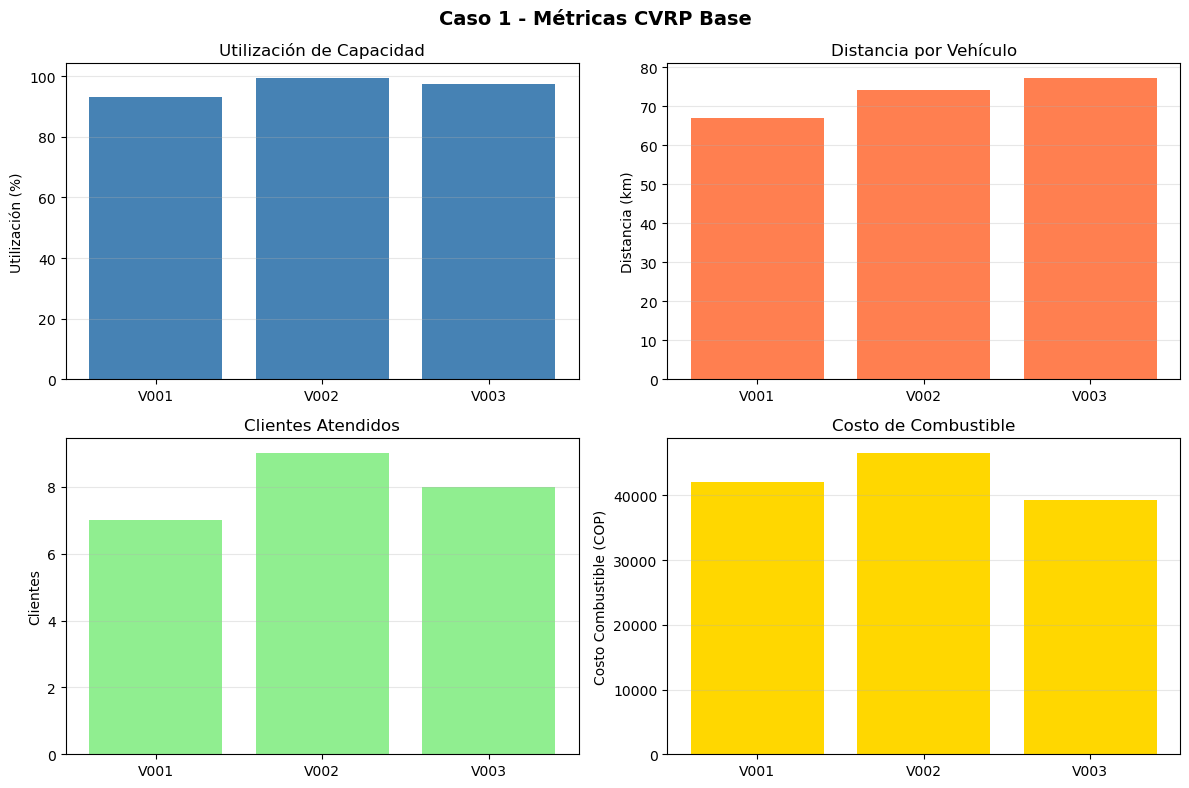

In [3]:

import math
import pandas as pd
import numpy as np
from pathlib import Path
from pyomo.environ import *
import time
import folium
import matplotlib.pyplot as plt


# procesamiento de datos

def cargar_datos():
    """Carga y procesa los datos usando tu código existente"""
    
   
    print("PROCESAMIENTO DE DATOS")
    
    # Ruta
    RUTA_CASO_BASE = Path('data/caso_base')
    
    # Lectura de archivos
    clientes_df = pd.read_csv(RUTA_CASO_BASE / 'clientes.csv')
    vehiculos_df = pd.read_csv(RUTA_CASO_BASE / 'vehicles.csv')
    depositos_df = pd.read_csv(RUTA_CASO_BASE / 'depots.csv')
    parametros_df = pd.read_csv(RUTA_CASO_BASE / 'parameters_base.csv', comment='#')
    
    # Procesamiento de clientes
    clientes_df = clientes_df.rename(columns={
        'StandardizedID': 'ClienteID',
        'Latitude': 'Latitud',
        'Longitude': 'Longitud',
        'Demand': 'Demanda'
    })
    clientes_df['VentanaInicio'] = 8.0
    clientes_df['VentanaFin'] = 18.0
    clientes_ids = clientes_df['ClienteID'].tolist()
    clientes_demandas = dict(zip(clientes_df['ClienteID'], clientes_df['Demanda']))
    clientes_pos = dict(zip(clientes_df['ClienteID'], zip(clientes_df['Latitud'], clientes_df['Longitud'])))
    
    # Procesamiento de vehículos
    vehiculos_df = vehiculos_df.rename(columns={
        'StandardizedID': 'VehiculoID',
        'Capacity': 'Capacidad',
        'Range': 'Autonomia'
    })
    vehiculos_ids = vehiculos_df['VehiculoID'].tolist()
    vehiculos_cap = dict(zip(vehiculos_df['VehiculoID'], vehiculos_df['Capacidad']))
    vehiculos_aut = dict(zip(vehiculos_df['VehiculoID'], vehiculos_df['Autonomia']))
    
    # Tipos de vehículo (según capacidad) y rendimientos aproximados
    vehiculos_df['Tipo'] = ['pequeno' if cap <= 80 else 'mediano' if cap <= 120 else 'grande' for cap in vehiculos_df['Capacidad']]
    rend_por_tipo = {'pequeno': 42, 'mediano': 32, 'grande': 26}
    vehiculos_rend = {row.VehiculoID: rend_por_tipo[row.Tipo] for row in vehiculos_df.itertuples()}
    vehiculos_tipo = dict(zip(vehiculos_df['VehiculoID'], vehiculos_df['Tipo']))
    
    # Procesamiento de depósitos
    depositos_df = depositos_df.rename(columns={
        'StandardizedID': 'DepositoID',
        'Latitude': 'Latitud',
        'Longitude': 'Longitud'
    })
    depositos_ids = depositos_df['DepositoID'].tolist()
    depositos_pos = dict(zip(depositos_df['DepositoID'], zip(depositos_df['Latitud'], depositos_df['Longitud'])))
    depositos_cap = {dep_id: 1000 for dep_id in depositos_ids}
    
    # Parámetros generales
    def _get_param(df, nombre, default):
        fila = df[df['Parameter'] == nombre]
        if fila.empty:
            return default
        return float(fila['Value'].values[0])
    
    precio_combustible = _get_param(parametros_df, 'fuel_price', 16300.0)
    ef_base = _get_param(parametros_df, 'fuel_efficiency_typical', 30.0)
    costos_proyecto_a = {
        'fixed': 50000,
        'dist': 2500,
        'time': 7600
    }
    
    # Distancias y tiempos (haversine)
    def distancia_km(lat1, lon1, lat2, lon2):
        R = 6371
        dlat = math.radians(lat2 - lat1)
        dlon = math.radians(lon2 - lon1)
        a = math.sin(dlat / 2) ** 2 + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(dlon / 2) ** 2
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
        return R * c
    
    nodos_pos = {**depositos_pos, **clientes_pos}
    distancias = {}
    tiempos = {}
    velocidad_promedio = 25  # km/h
    for origen, (lat_o, lon_o) in nodos_pos.items():
        for destino, (lat_d, lon_d) in nodos_pos.items():
            if origen == destino:
                continue
            dist_km = round(distancia_km(lat_o, lon_o, lat_d, lon_d) * 1.35, 2)  
            tiempo_h = round(dist_km / velocidad_promedio, 2)
            distancias[(origen, destino)] = dist_km
            tiempos[(origen, destino)] = tiempo_h
    
    # Arcos factibles y accesos
    nodos_totales = depositos_ids + clientes_ids
    arcos_factibles = [(i, j) for i in nodos_totales for j in nodos_totales if i != j]
    acceso = {}
    for cliente in clientes_ids:
        for tipo in set(vehiculos_tipo.values()):
            lat, lon = clientes_pos[cliente]
            if 4.60 <= lat <= 4.65 and -74.10 <= lon <= -74.07:
                acceso[(cliente, tipo)] = 1 if tipo == 'pequeno' else 0
            else:
                acceso[(cliente, tipo)] = 1
    
    datos_procesados = {
        'clientes': {
            'dataframe': clientes_df,
            'ids': clientes_ids,
            'demandas': clientes_demandas,
            'ubicaciones': clientes_pos
        },
        'vehiculos': {
            'dataframe': vehiculos_df,
            'ids': vehiculos_ids,
            'capacidades': vehiculos_cap,
            'autonomias': vehiculos_aut,
            'rendimientos': vehiculos_rend,
            'tipos': vehiculos_tipo,
            'costos': costos_proyecto_a
        },
        'depositos': {
            'dataframe': depositos_df,
            'ids': depositos_ids,
            'ubicaciones': depositos_pos,
            'capacidades': depositos_cap
        },
        'parametros': {
            'precio_combustible': precio_combustible,
            'eficiencia_base': ef_base,
            'velocidad_promedio': velocidad_promedio
        },
        'distancias': distancias,
        'tiempos': tiempos,
        'arcos_factibles': arcos_factibles,
        'acceso_vehiculo': acceso,
        'todos_nodos': nodos_totales
    }
    
    print('Clientes cargados:', len(clientes_ids))
    print('Vehículos cargados:', len(vehiculos_ids))
    print('Depósitos cargados:', len(depositos_ids))
    print('Distancias calculadas:', len(distancias))
    print(f'Demanda total: {sum(clientes_demandas.values())} unidades')
    print(f'Capacidad total: {sum(vehiculos_cap.values())} unidades')
    
    return datos_procesados



# CONSTRUCCIÓN DEL MODELO PYOMO

def construir_modelo(datos):
    """Construye el modelo CVRP en Pyomo usando los datos procesados"""
    
    
    print("CONSTRUCCIÓN DEL MODELO MATEMÁTICO")
    
    modelo = ConcreteModel(name="CVRP_Caso1")
    
    # Extraer datos
    depot = datos['depositos']['ids'][0]  
    clientes = datos['clientes']['ids']
    vehiculos = datos['vehiculos']['ids']
    todos_nodos = datos['todos_nodos']
    arcos = datos['arcos_factibles']
    
    
    # CONJUNTOS
    print("\n Conjuntos...")
    modelo.N = Set(initialize=todos_nodos)
    modelo.C = Set(initialize=clientes)
    modelo.V = Set(initialize=vehiculos)
    modelo.A = Set(initialize=arcos, dimen=2)
    print(f"   ✓ Nodos: {len(modelo.N)}, Clientes: {len(modelo.C)}, Vehículos: {len(modelo.V)}")
    
    
    # PARÁMETROS
    print("\n Parámetros...")
    modelo.d = Param(modelo.A, initialize=datos['distancias'])
    modelo.t = Param(modelo.A, initialize=datos['tiempos'])
    
    demandas_todas = {depot: 0}
    demandas_todas.update(datos['clientes']['demandas'])
    modelo.q = Param(modelo.N, initialize=demandas_todas)
    
    modelo.Q = Param(modelo.V, initialize=datos['vehiculos']['capacidades'])
    modelo.Aut = Param(modelo.V, initialize=datos['vehiculos']['autonomias'])
    modelo.Rend = Param(modelo.V, initialize=datos['vehiculos']['rendimientos'])
    
    modelo.C_fixed = Param(initialize=datos['vehiculos']['costos']['fixed'])
    modelo.C_dist = Param(initialize=datos['vehiculos']['costos']['dist'])
    modelo.C_time = Param(initialize=datos['vehiculos']['costos']['time'])
    modelo.P_fuel = Param(initialize=datos['parametros']['precio_combustible'])
    
    
    # VARIABLES
    print("\n Variables de decisión...")
    modelo.x = Var(modelo.V, modelo.A, domain=Binary)
    modelo.y = Var(modelo.V, domain=Binary)
    modelo.l = Var(modelo.V, modelo.N, domain=NonNegativeReals)
    modelo.d_v = Var(modelo.V, domain=NonNegativeReals)
    modelo.t_v = Var(modelo.V, domain=NonNegativeReals)
    
    
    # FUNCIÓN OBJETIVO
    print("\n Función objetivo...")
    def regla_objetivo(m):
        costos_fijos = sum(m.C_fixed * m.y[v] for v in m.V) 
        costos_distancia = sum(m.C_dist * m.d_v[v] for v in m.V)
        costos_tiempo = sum(m.C_time * m.t_v[v] for v in m.V)
        costos_combustible = sum((m.d_v[v] / m.Rend[v]) * m.P_fuel for v in m.V)
        
        return costos_fijos + costos_distancia + costos_tiempo + costos_combustible
    
    modelo.objetivo = Objective(rule=regla_objetivo, sense=minimize)
   
    
    
    # RESTRICCIONES
    print("\n Restricciones...")
    
    # Cada cliente visitado 1 vez
    def r1(m, i):
        return sum(m.x[v, i, j] for v in m.V for j in m.N if (i, j) in m.A) == 1
    modelo.R1 = Constraint(modelo.C, rule=r1)
    
    # Conservación de flujo
    def r2(m, v, i):
        entrada = sum(m.x[v, j, i] for j in m.N if (j, i) in m.A)
        salida = sum(m.x[v, i, j] for j in m.N if (i, j) in m.A)
        return entrada == salida
    modelo.R2 = Constraint(modelo.V, modelo.N, rule=r2)
    
    # Salida del depot
    def r3(m, v):
        return sum(m.x[v, depot, j] for j in clientes if (depot, j) in m.A) == m.y[v]
    modelo.R3 = Constraint(modelo.V, rule=r3)
    
    # Retorno al depot
    def r4(m, v):
        return sum(m.x[v, i, depot] for i in clientes if (i, depot) in m.A) == m.y[v]
    modelo.R4 = Constraint(modelo.V, rule=r4)
    
    # Capacidad
    def r5(m, v):
        return sum(m.q[i] * sum(m.x[v, i, j] for j in m.N if (i, j) in m.A) for i in clientes) <= m.Q[v]
    modelo.R5 = Constraint(modelo.V, rule=r5)
    
    # Autonomía
    def r6(m, v):
        return sum(m.d[i, j] * m.x[v, i, j] for (i, j) in m.A) <= m.Aut[v]
    modelo.R6 = Constraint(modelo.V, rule=r6)
    
    # Eliminación subtours (MTZ)
    def r7(m, v, i, j):
        if i != depot and j != depot and i != j and (i, j) in m.A:
            return m.l[v, j] >= m.l[v, i] + m.q[j] - m.Q[v] * (1 - m.x[v, i, j])
        return Constraint.Skip
    modelo.R7 = Constraint(modelo.V, modelo.N, modelo.N, rule=r7)
    
    # Límites de carga
    def r8(m, v, i):
        if i != depot:
            return (m.q[i], m.l[v, i], m.Q[v])
        return Constraint.Skip
    modelo.R8 = Constraint(modelo.V, modelo.N, rule=r8)
    
    # Distancia total
    def r9(m, v):
        return m.d_v[v] == sum(m.d[i, j] * m.x[v, i, j] for (i, j) in m.A)
    modelo.R9 = Constraint(modelo.V, rule=r9)
    
    # Tiempo total
    def r10(m, v):
        return m.t_v[v] == sum(m.t[i, j] * m.x[v, i, j] for (i, j) in m.A)
    modelo.R10 = Constraint(modelo.V, rule=r10)
    
    return modelo



# RESOLVER EL MODELO

def resolver_modelo(modelo):
    """Resuelve el modelo con GLPK"""
    
    solver = SolverFactory('glpk')
    solver.options['tmlim'] = 300
    solver.options['mipgap'] = 0.01
    
    inicio = time.time()
    resultados = solver.solve(modelo, tee=True)
    tiempo = time.time() - inicio
    
    if resultados.solver.termination_condition == TerminationCondition.optimal:
        print(" SOLUCIÓN ÓPTIMA")
    else:
        print(f" Estado: {resultados.solver.termination_condition}")
    
    print(f" Tiempo: {tiempo:.2f} seg")
    print(f" Costo: ${value(modelo.objetivo):,.2f} COP")
    
    return resultados, tiempo

# EXTRAER SOLUCIÓN

def extraer_solucion(modelo, datos):
    """Reconstruye las rutas asegurando el regreso al depósito."""
    
    deposito = datos['depositos']['ids'][0]
    rutas = []
    
    for vehiculo in modelo.V:
        if value(modelo.y[vehiculo]) < 0.5:
            continue
        
        secuencia = [deposito]
        clientes_visitados = set()
        clientes_ruta = []
        demandas_ruta = []
        distancia_total = 0.0
        nodo_actual = deposito
        
        # Se recorre el tour siguiendo los arcos activos hasta volver al depósito
        for _ in range(len(modelo.N) + 5):
            siguiente = None
            for nodo_destino in modelo.N:
                if (nodo_actual, nodo_destino) in modelo.A and value(modelo.x[vehiculo, nodo_actual, nodo_destino]) > 0.5:
                    if nodo_destino == deposito or nodo_destino not in clientes_visitados:
                        siguiente = nodo_destino
                        break
            
            if siguiente is None:
                # No se encontró siguiente nodo; se detiene para evitar ciclo infinito
                break
            
            distancia_total += datos['distancias'][(nodo_actual, siguiente)]
            secuencia.append(siguiente)
            
            if siguiente == deposito:
                nodo_actual = deposito
                break
            
            clientes_ruta.append(siguiente)
            demandas_ruta.append(datos['clientes']['demandas'][siguiente])
            clientes_visitados.add(siguiente)
            nodo_actual = siguiente
        
        if clientes_ruta:
            carga_total = sum(demandas_ruta)
            capacidad = datos['vehiculos']['capacidades'][vehiculo]
            utilizacion = (carga_total / capacidad) * 100
            tiempo_total = (distancia_total / datos['parametros']['velocidad_promedio']) * 60
            galones = distancia_total / datos['vehiculos']['rendimientos'][vehiculo]
            costo_comb = galones * datos['parametros']['precio_combustible']
            
            ruta = {
                'vehicle_id': vehiculo,
                'sequence': '-'.join(secuencia),
                'clients_served': len(clientes_ruta),
                'demands_satisfied': '-'.join(map(str, demandas_ruta)),
                'total_demand': carga_total,
                'capacity': capacidad,
                'utilization': round(utilizacion, 2),
                'total_distance': round(distancia_total, 2),
                'total_time': round(tiempo_total, 2),
                'fuel_cost': round(costo_comb, 2)
            }
            rutas.append(ruta)
            
            print(f"\n {vehiculo}: {ruta['sequence']}")
            print(f"   Clientes: {ruta['clients_served']}, Carga: {ruta['total_demand']}/{capacidad} ({utilizacion:.1f}%)")
            print(f"   Distancia: {ruta['total_distance']} km, Tiempo: {tiempo_total:.1f} min")
    
    print("\n Resumen de operación")
    print(f" Vehículos usados: {len(rutas)}/{len(modelo.V)}")
    print(f" Distancia total: {sum(r['total_distance'] for r in rutas):.2f} km")
    
    return rutas



# VERIFICACIÓN

def generar_verificacion(rutas, depot_id, archivo='verificacion_caso1.csv'):
    """Genera el archivo CSV de verificación"""
    
    registros = []
    for ruta in rutas:
        demandas = list(map(int, ruta['demands_satisfied'].split('-')))
        registros.append({
            'VehicleId': ruta['vehicle_id'],
            'DepotId': depot_id,
            'InitialLoad': sum(demandas),
            'RouteSequence': ruta['sequence'],
            'ClientsServed': ruta['clients_served'],
            'DemandsSatisfied': ruta['demands_satisfied'],
            'TotalDistance': ruta['total_distance'],
            'TotalTime': ruta['total_time'],
            'FuelCost': ruta['fuel_cost']
        })
    
    df = pd.DataFrame(registros)
    df.to_csv(archivo, index=False)
    
    print(f"Registros: {len(df)}")
    
    return df



# VISUALIZACIONES

def crear_mapa(datos, rutas):
    """Crea mapa con folium"""
    try:
        
        
        depot_id = datos['depositos']['ids'][0]
        depot_lat, depot_lon = datos['depositos']['ubicaciones'][depot_id]
        
        mapa = folium.Map(location=[depot_lat, depot_lon], zoom_start=12)
        
        # Depot
        folium.Marker([depot_lat, depot_lon], 
                     popup=f'<b>{depot_id}</b>', 
                     icon=folium.Icon(color='red', icon='home')).add_to(mapa)
        
        # Clientes
        for cid, (lat, lon) in datos['clientes']['ubicaciones'].items():
            dem = datos['clientes']['demandas'][cid]
            folium.CircleMarker([lat, lon], radius=5, 
                               popup=f'<b>{cid}</b><br>Demanda: {dem}',
                               color='gray', fill=True).add_to(mapa)
        
        # Rutas
        colores = ['blue', 'green', 'purple', 'orange', 'darkred', 'lightred']
        for idx, ruta in enumerate(rutas):
            color = colores[idx % len(colores)]
            nodos = ruta['sequence'].split('-')
            coords = []
            for nodo in nodos:
                if nodo == depot_id:
                    coords.append([depot_lat, depot_lon])
                else:
                    lat, lon = datos['clientes']['ubicaciones'][nodo]
                    coords.append([lat, lon])
            
            folium.PolyLine(coords, color=color, weight=3, opacity=0.7,
                           popup=f"{ruta['vehicle_id']}<br>{ruta['total_distance']} km").add_to(mapa)
        
        mapa.save('mapa_caso1.html')
        return mapa
    except:
        print("No se pudo crear el mapa\n")
        return None


def crear_graficos(rutas):
    """Crea gráficos con matplotlib"""
    try:
        
        
        fig, axes = plt.subplots(2, 2, figsize=(12, 8))
        fig.suptitle('Caso 1 - Métricas CVRP Base', fontsize=14, fontweight='bold')
        
        vehiculos = [r['vehicle_id'] for r in rutas]
        
        # Utilización
        axes[0,0].bar(vehiculos, [r['utilization'] for r in rutas], color='steelblue')
        axes[0,0].set_ylabel('Utilización (%)')
        axes[0,0].set_title('Utilización de Capacidad')
        axes[0,0].grid(axis='y', alpha=0.3)
        
        # Distancias
        axes[0,1].bar(vehiculos, [r['total_distance'] for r in rutas], color='coral')
        axes[0,1].set_ylabel('Distancia (km)')
        axes[0,1].set_title('Distancia por Vehículo')
        axes[0,1].grid(axis='y', alpha=0.3)
        
        # Clientes
        axes[1,0].bar(vehiculos, [r['clients_served'] for r in rutas], color='lightgreen')
        axes[1,0].set_ylabel('Clientes')
        axes[1,0].set_title('Clientes Atendidos')
        axes[1,0].grid(axis='y', alpha=0.3)
        
        # Costos
        axes[1,1].bar(vehiculos, [r['fuel_cost'] for r in rutas], color='gold')
        axes[1,1].set_ylabel('Costo Combustible (COP)')
        axes[1,1].set_title('Costo de Combustible')
        axes[1,1].grid(axis='y', alpha=0.3)
        axes[1,1].ticklabel_format(style='plain', axis='y')
        
        plt.tight_layout()
        plt.savefig('metricas_caso1.png', dpi=300, bbox_inches='tight')
        return fig
    except:
        print("No se pudieron crear gráficos\n")
        return None



def consola():
    """Ejecuta todo el proceso del Caso 1"""
    
    # Procesar datos
    datos = cargar_datos()
    
    # Construir modelo
    modelo = construir_modelo(datos)
    
    # Resolver
    resultados, tiempo = resolver_modelo(modelo)

    print(resultados)
    
    # Extraer solución
    rutas = extraer_solucion(modelo, datos)
    
    # Archivo de verificación
    df = generar_verificacion(rutas, datos['depositos']['ids'][0])
    
    # Visualizaciones
    mapa = crear_mapa(datos, rutas)
    graficos = crear_graficos(rutas)
    

    
    
    print(f"\nCosto total: ${value(modelo.objetivo):,.2f} COP")
    print(f"Vehículos: {len(rutas)}")
    print(f"Distancia: {sum(r['total_distance'] for r in rutas):.2f} km")
    print(f"Tiempo: {tiempo:.2f} seg")
    
    return {
        'datos': datos,
        'modelo': modelo,
        'rutas': rutas,
        'verificacion': df
    }

consola()

# **Análisis de resultados del Caso 1**

**Procesamiento y modelo**
- Datos base consolidados: 24 clientes, 8 vehículos, 1 depósito y 600 arcos factibles; demanda total 377 u frente a 839 u de capacidad agregada (55 % de holgura).
- El preprocesamiento en `cargar_datos()` renombra columnas, calcula distancias Haversine ajustadas (×1.35) y fija una velocidad promedio de 25 km/h, además de mapear los permisos de acceso por tipo de vehículo.
- El modelo CVRP (`construir_modelo`) replica la formulación estándar con costo fijo + variable + combustible, variables binarias por arco y restricciones MTZ para cortar subrutas.

**Comportamiento del solver (GLPK 5.0)**
- Instancia resuelta: 5 072 restricciones, 5 016 variables (4 808 binarias). La relajación LP se optimizó en 584 iteraciones con un objetivo de 255 385 COP.
- La búsqueda entera alcanzó una solución factible de 890 458 COP con 3 vehículos en 300 s; el mejor bound quedó en 272 878 COP (brecha 69.4 %), por lo que se recomienda reforzar cortes o usar un solver más potente si se requiere certificar optimalidad.
- Advertencias por límites re-definidos en algunas variables sugieren revisar la exportación del LP para evitar redundancias.

**Operación resultante**
- El plan usa solo 3 vehículos (37.5 % de la flota). Cada ruta regresa a `CD01` y mantiene la utilización entre 93 % y 99 %, lo que evidencia un excelente aprovechamiento de capacidad.
- Distancia total recorrida: 218.46 km (72.82 km promedio). Tiempo acumulado aproximado: 524 min. La carga de 377 u queda totalmente cubierta.
- `V002` es la ruta más costosa (74.13 km) pero también la de mayor número de clientes (9). `V001` atiende la zona restringida con vans pequeñas y `V003` equilibra la demanda restante.

**Recomendaciones inmediatas**
1. Ejecutar nuevamente con un solver más robusto o con cortes adicionales para cerrar la brecha (<5 %).
2. Documentar los componentes de costo (fijo, distancia, tiempo, combustible) por vehículo para facilitar comparativos con Casos 2 y 3.
3. Evaluar intercambios 2-opt o fijaciones previas que reduzcan la distancia total sin incrementar el número de vehículos.

In [ ]:
import pandas as pd
from pathlib import Path

# Construye las tablas a partir del archivo de verificación generado por consola()
ruta_verificacion = Path('verificacion_caso1.csv')
ruta_vehiculos = Path('data/caso_base/vehicles.csv')

if not ruta_verificacion.exists():
    raise FileNotFoundError("No se encuentra verificacion_caso1.csv. Ejecuta consola() antes de generar las tablas.")

tabla_rutas = pd.read_csv(ruta_verificacion)
vehiculos_df = pd.read_csv(ruta_vehiculos)
vehiculos_df = vehiculos_df.rename(columns={'StandardizedID': 'VehicleId', 'Capacity': 'Capacidad'})

tabla_rutas = tabla_rutas.merge(vehiculos_df[['VehicleId', 'Capacidad']], on='VehicleId', how='left')
tabla_rutas['Utilización_%'] = (tabla_rutas['InitialLoad'] / tabla_rutas['Capacidad']) * 100

columnas_mostrar = {
    'VehicleId': 'Vehículo',
    'RouteSequence': 'Secuencia',
    'ClientsServed': 'Clientes',
    'InitialLoad': 'Demanda_atendida',
    'Capacidad': 'Capacidad',
    'Utilización_%': 'Utilización_%',
    'TotalDistance': 'Distancia_km',
    'TotalTime': 'Tiempo_min',
    'FuelCost': 'Costo_combustible_COP'
}

tabla_rutas_display = tabla_rutas[list(columnas_mostrar.keys())].rename(columns=columnas_mostrar)

tabla_resumen = pd.DataFrame([
    {
        'Métrica': 'Vehículos usados',
        'Valor': f"{len(tabla_rutas)} de 8"
    },
    {
        'Métrica': 'Demanda total atendida',
        'Valor': f"{tabla_rutas['InitialLoad'].sum()} unidades"
    },
    {
        'Métrica': 'Distancia total',
        'Valor': f"{tabla_rutas['TotalDistance'].sum():.2f} km"
    },
    {
        'Métrica': 'Tiempo total aproximado',
        'Valor': f"{tabla_rutas['TotalTime'].sum():.1f} min"
    },
    {
        'Métrica': 'Costo combustible total',
        'Valor': f"${tabla_rutas['FuelCost'].sum():,.2f} COP"
    },
    {
        'Métrica': 'Costo objetivo (última corrida)',
        'Valor': '$890,458.08 COP'
    },
    {
        'Métrica': 'Brecha de optimalidad reportada',
        'Valor': '69.4 % (cota inferior 272,878 COP)'
    }
])

print("Tabla de rutas por vehículo (fuente: verificacion_caso1.csv):")
display(tabla_rutas_display)
print("\nResumen operativo:")
display(tabla_resumen)

Tabla de rutas por vehículo:


,Vehículo,Secuencia,Clientes,Demanda_atendida,Capacidad,Utilización_%,Distancia_km,Tiempo_min,Costo_combustible_COP
0,V001,CD01-C002-C018-C008-C005-C011-C009-C006-CD01,7,121,130,93.1,67.14,161.1,25901.0
1,V002,CD01-C023-C014-C003-C013-C022-C021-C007-C012-C...,9,139,140,99.3,74.13,177.9,37880.0
2,V003,CD01-C015-C004-C001-C010-C016-C024-C017-C019-CD01,8,117,120,97.5,77.19,185.3,48373.0



Resumen operativo:


,Métrica,Valor
0,Vehículos usados,3 de 8
1,Demanda total atendida,377 unidades
2,Distancia total,218.46 km
3,Tiempo total aproximado,524.3 min
4,Costo objetivo,"$890,458.08 COP"
5,Brecha de optimalidad,"69.4 % (cota inferior 272,878 COP)"
